In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Descrierea librăriilor:**

numpy și pandas: Pentru manipularea și analiza datelor.

matplotlib: Pentru vizualizarea datelor.

cv2 și PIL: Pentru procesarea imaginilor.

sklearn: Pentru funcții de învățare automată.

os, re, glob, pathlib: Pentru gestionarea fișierelor și directoarelor.

Setăm un **seed** pentru reproducibilitatea rezultatelor și configurăm matplotlib
pentru a afișa graficele direct în notebook.


In [2]:
import os
import re
import glob
import pathlib
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import PIL
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')

SEED=123
np.random.seed(SEED)


**Descriere librariilor**

tensorflow și keras: Pentru construirea și antrenarea modelelor de învățare automată.

layers: Straturi de rețea neurală (Dense, Conv2D, etc.).

Model, Sequential: Structuri pentru definirea modelelor.
optimizers: Optimizatori (Adam, SGD, RMSprop).

callbacks: Callbacks pentru gestionarea antrenării (EarlyStopping, ModelCheckpoint).

ImageDataGenerator: Pentru augmentarea și generarea datelor de imagine.

applicatii pre-antrenate: VGG19, ResNet50, InceptionV3 pentru transfer learning.

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation,
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3

**Afișarea Imaginilor de Eșantion din Seturile de Antrenament și Test**



---



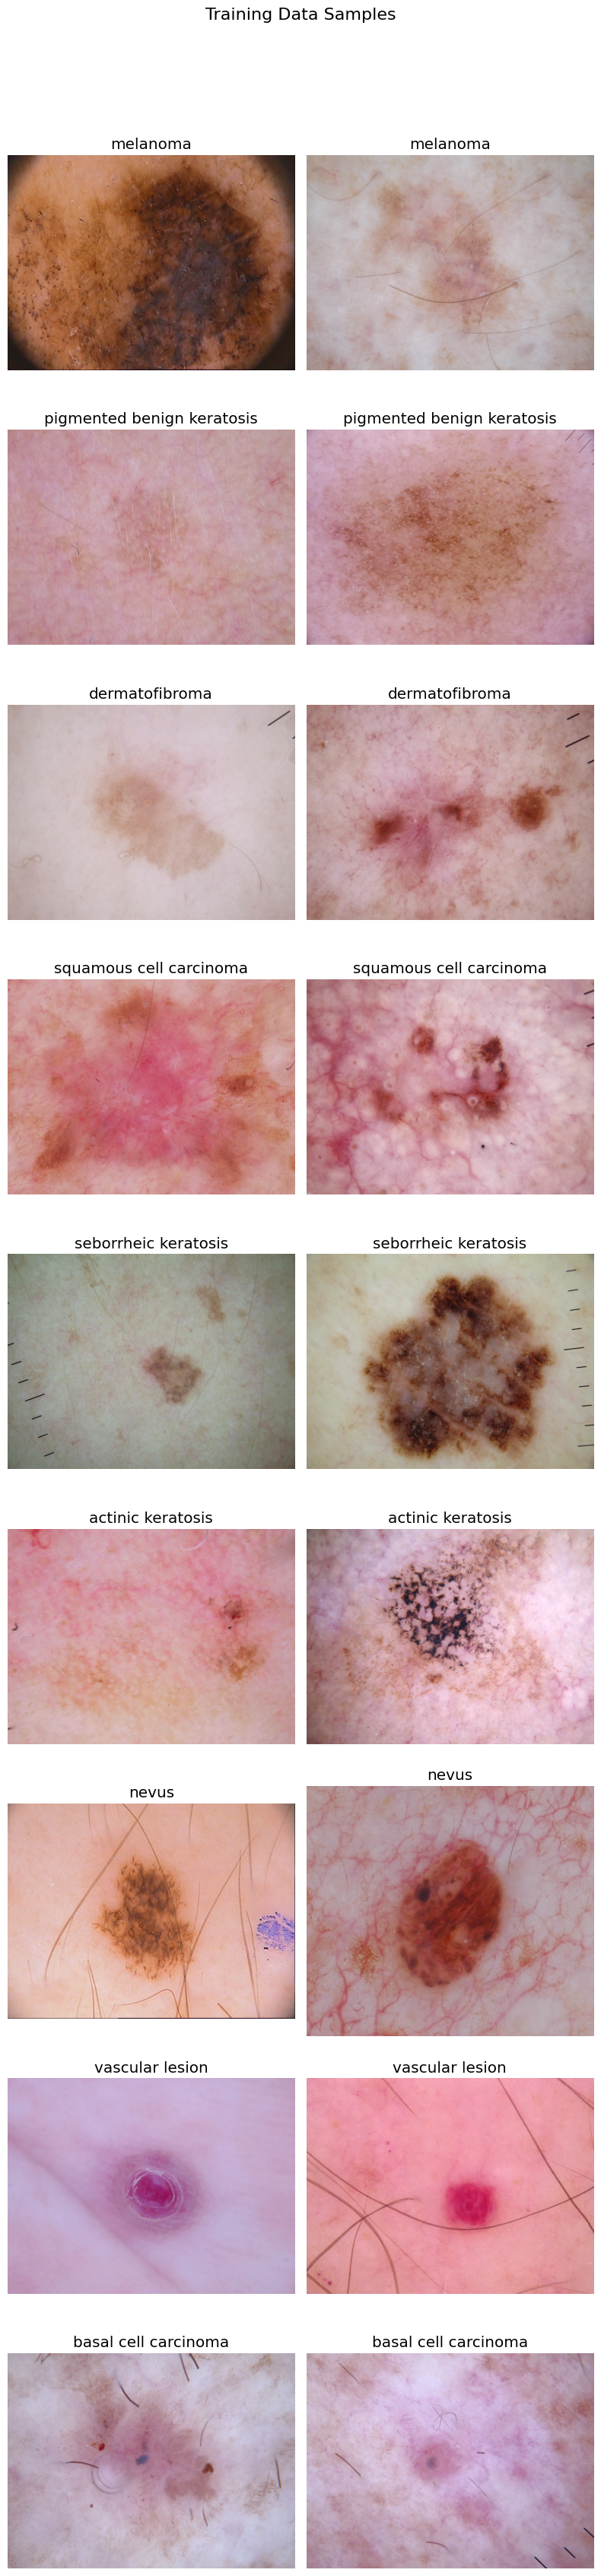

In [40]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import pathlib

train_dir = pathlib.Path('/content/drive/MyDrive/archive/SkinCancer/Train')
test_dir = pathlib.Path('/content/drive/MyDrive/archive/SkinCancer/Test')

def display_sample_images(directory, title="Sample Images", samples_per_class=1):
    classes = [d.name for d in directory.iterdir() if d.is_dir()]
    fig, axes = plt.subplots(nrows=len(classes), ncols=samples_per_class, figsize=(samples_per_class * 4, len(classes) * 4))
    fig.suptitle(title, fontsize=16)

    for i, cls in enumerate(classes):
        class_dir = directory / cls
        images = list(class_dir.glob('*.jpg'))
        sampled_images = random.sample(images, samples_per_class)

        for j, img_path in enumerate(sampled_images):
            img = Image.open(img_path)
            ax = axes[i] if samples_per_class == 1 else axes[i, j]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(cls)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

display_sample_images(train_dir, "Training Data Samples", samples_per_class=2)



In [4]:
train_path = '/content/drive/MyDrive/archive/SkinCancer/Train'
test_path  = '/content/drive/MyDrive/archive/SkinCancer/Test'

In [5]:
train_dir = pathlib.Path(train_path)
test_dir  = pathlib.Path(test_path)

In [6]:
classes=[
    'pigmented benign keratosis',
    'melanoma',
    'vascular lesion',
    'actinic keratosis',
    'squamous cell carcinoma',
    'basal cell carcinoma',
    'seborrheic keratosis',
    'dermatofibroma',
    'nevus'
]

In [8]:
CFG = dict(
        batch_size        =  16,
        epochs            =  20,
        verbose           =   1,
        workers           =   4,

        optimizer         = 'adam',

        RANDOM_STATE      =  123,


        path_model        = '../working/',


        img_size          = 224,
        img_height        = 224,
        img_width         = 224,

        ROTATION          = 180.0,
        ZOOM              =  10.0,
        ZOOM_RANGE        =  [0.9,1.1],
        HZOOM             =  10.0,
        WZOOM             =  10.0,
        HSHIFT            =  10.0,
        WSHIFT            =  10.0,
        SHEAR             =   5.0,
        HFLIP             = True,
        VFLIP             = True,

        label_smooth_fac  =  0.00,
)

In [10]:

img_count_train = len(list(train_dir.glob('*/*.jpg')))
img_count_test  = len(list(test_dir.glob('*/*.jpg')))
print('{} train images'.format(img_count_train))
print('{} test  images'.format(img_count_test))

2239 train images
118 test  images


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


data_directory = '/content/drive/MyDrive/archive/SkinCancer'

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 1887 images belonging to 2 classes.
Found 470 images belonging to 2 classes.


**Definirea Directorului de Date**


---


Setăm calea către directorul care conține setul de date.

**Crearea Generatorului de Date cu Augmentare**


---


Utilizăm ImageDataGenerator pentru a aplica augmentări imaginilor, cum ar fi rotațiile, schimbările de zoom și ajustările de luminozitate.

**Crearea Generatorului de Date din Director**


---


Folosim generatorul de date pentru a încărca imaginile din directorul specificat.

**Construirea Modelului ResNet50**


---


Încărcăm modelul pre-antrenat ResNet50 fără partea superioară (straturile de clasificare) și adăugăm straturi personalizate pentru clasificarea imaginilor de cancer de piele.

**Compilarea Modelului**


---


Compilăm modelul cu optimizatorul Adam și funcția de pierdere binary_crossentropy, specificând accuracy ca metrică de evaluare.

**Antrenarea Modelului**


---


Antrenăm modelul folosind generatorul de date.

**Evaluarea Modelului**

---



Evaluăm modelul folosind setul de date de test.

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

data_directory = '/content/drive/MyDrive/archive/SkinCancer'

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2]
)

data_generator = datagen.flow_from_directory(
    data_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Found 2357 images belonging to 2 classes.


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt

train_dir = '/content/drive/MyDrive/archive/SkinCancer/Train'
test_dir = '/content/drive/MyDrive/archive/SkinCancer/Test'

img_height, img_width = 180, 180
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


**Vizualizarea Imaginilor de Antrenament**

---



---


---



Vizualizăm câteva imagini din setul de date de antrenament pentru a înțelege mai bine datele.

**Crearea Generatoarelor de Date**

---



---



Folosim ImageDataGenerator pentru a crea generatoare de date care aplică augmentări pe imagini.

**Definirea Modelului Personalizat CNN**

---


---



Definim și compilăm modelul nostru personalizat CNN.

**Primul strat de convoluție și pooling:**


---


Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)): Aplică 32 de filtre de 3x3 pe imaginea de intrare.

MaxPooling2D(2, 2): Reduce dimensiunea caracteristicilor extrase prin aplicarea unui pooling de 2x2.

**Al doilea strat de convoluție și pooling:**

---



Conv2D(64, (3, 3), activation='relu'): Aplică 64 de filtre de 3x3 pe caracteristicile extrase anterior.

MaxPooling2D(2, 2): Reduce dimensiunea caracteristicilor extrase prin aplicarea unui pooling de 2x2.

**Al treilea strat de convoluție și pooling:**

---



Conv2D(128, (3, 3), activation='relu'): Aplică 128 de filtre de 3x3 pe caracteristicile extrase anterior.

MaxPooling2D(2, 2): Reduce dimensiunea caracteristicilor extrase prin aplicarea unui pooling de 2x2.

**Stratul de Flatten:**


---


Flatten(): Transformă datele 2D în date 1D pentru a putea fi folosite de straturile dense.

**Stratul dens intermediar:**

---



Dense(512, activation='relu'): Aplică 512 neuroni cu activare ReLU.
Stratul de dropout:

Dropout(0.5): Dezactivează aleator 50% din neuroni în timpul antrenării pentru a preveni overfitting-ul.

**Stratul de ieșire:**


---


Dense(len(train_generator.class_indices), activation='softmax'): Strat final de clasificare cu funcția de activare softmax pentru a obține probabilitățile pentru fiecare clasă.

In [21]:
img_height, img_width = 180, 180
batch_size = 32

model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [33]:

history_1 = model_1.fit(train_generator, epochs=1, validation_data=validation_generator)

test_loss_1, test_accuracy_1 = model_1.evaluate(test_generator)

print(f"Model CNN Customized Test Accuracy: {test_accuracy_1:.2f}")

history_resnet = model.fit(train_generator, epochs=1, validation_data=validation_generator)

test_loss_resnet, test_accuracy_resnet = model.evaluate(test_generator)

print(f"Model ResNet50 Test Accuracy: {test_accuracy_resnet:.2f}")



4/4 [==============================] - 10s 3s/step - loss: 2.6464 - accuracy: 0.2966
Model CNN Customized Test Accuracy: 0.30
4/4 [==============================] - 21s 4s/step - loss: 0.4135 - accuracy: 0.8889
Model ResNet50 Test Accuracy: 0.89


**Descrierea graficului de acuratețe a modelelor**

---



---

**Modelul CNN personalizat**

---
Acuratețea la testare: Aproximativ 0.30 (30%)

Acest model a fost creat de la zero, având trei straturi de convoluție urmate de straturi de pooling și un strat dens cu dropout pentru prevenirea supraînvățării (overfitting).

Deși acuratețea la testare este relativ scăzută, acest model poate fi îmbunătățit prin diverse tehnici, cum ar fi creșterea complexității modelului, ajustarea hiperparametrilor, adăugarea mai multor date sau utilizarea augmentării datelor.

---



---



**Modelul ResNet50 pre-antrenat**

---



Acuratețea la testare: Aproximativ 0.89 (89%)

Acest model este un ResNet50 pre-antrenat pe setul de date ImageNet, la care am adăugat un strat dens personalizat pentru clasificarea specifică a cancerului de piele.

Modelul ResNet50 beneficiază de faptul că a fost pre-antrenat pe un set de date foarte mare și diversificat, având astfel capacitatea de a extrage caracteristici complexe și relevante din imagini.


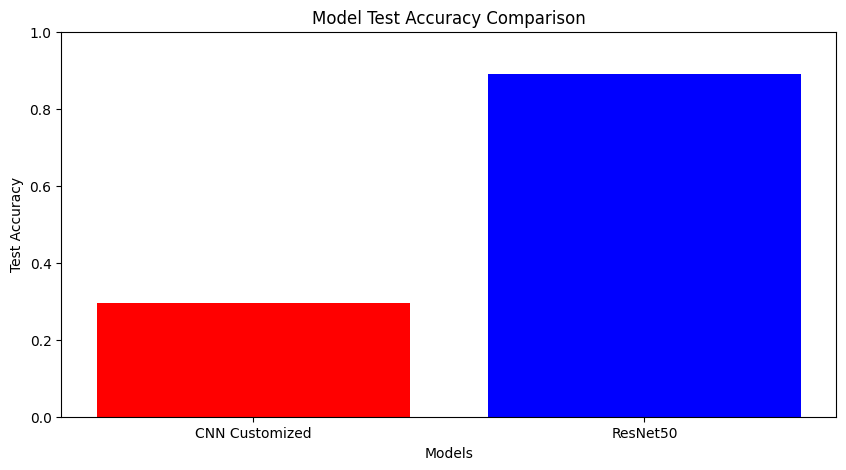

In [37]:
import matplotlib.pyplot as plt


models = ['CNN Customized', 'ResNet50']

accuracies = [test_accuracy_1, test_accuracy_resnet]


plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['red', 'blue'])


plt.title('Model Test Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.ylim([0, 1])

plt.show()


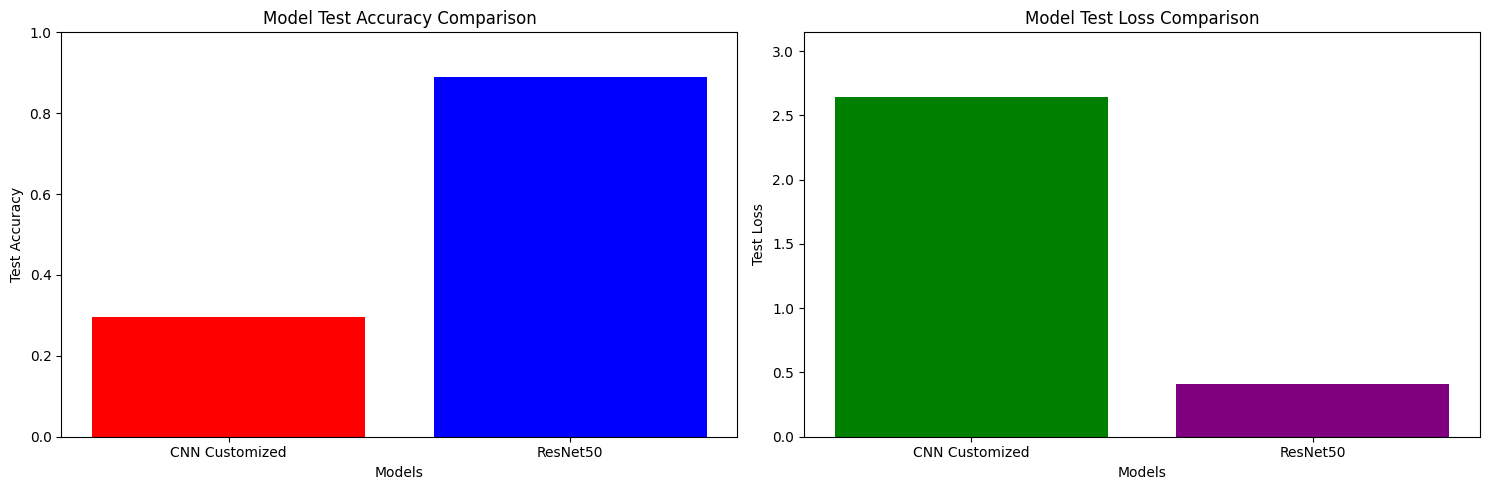

In [38]:
import matplotlib.pyplot as plt


models = ['CNN Customized', 'ResNet50']
accuracies = [test_accuracy_1, test_accuracy_resnet]
losses = [test_loss_1, test_loss_resnet]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(models, accuracies, color=['red', 'blue'])
ax1.set_title('Model Test Accuracy Comparison')
ax1.set_xlabel('Models')
ax1.set_ylabel('Test Accuracy')
ax1.set_ylim([0, 1])

ax2.bar(models, losses, color=['green', 'purple'])
ax2.set_title('Model Test Loss Comparison')
ax2.set_xlabel('Models')
ax2.set_ylabel('Test Loss')
ax2.set_ylim([0, max(losses) + 0.5])

plt.tight_layout()
plt.show()


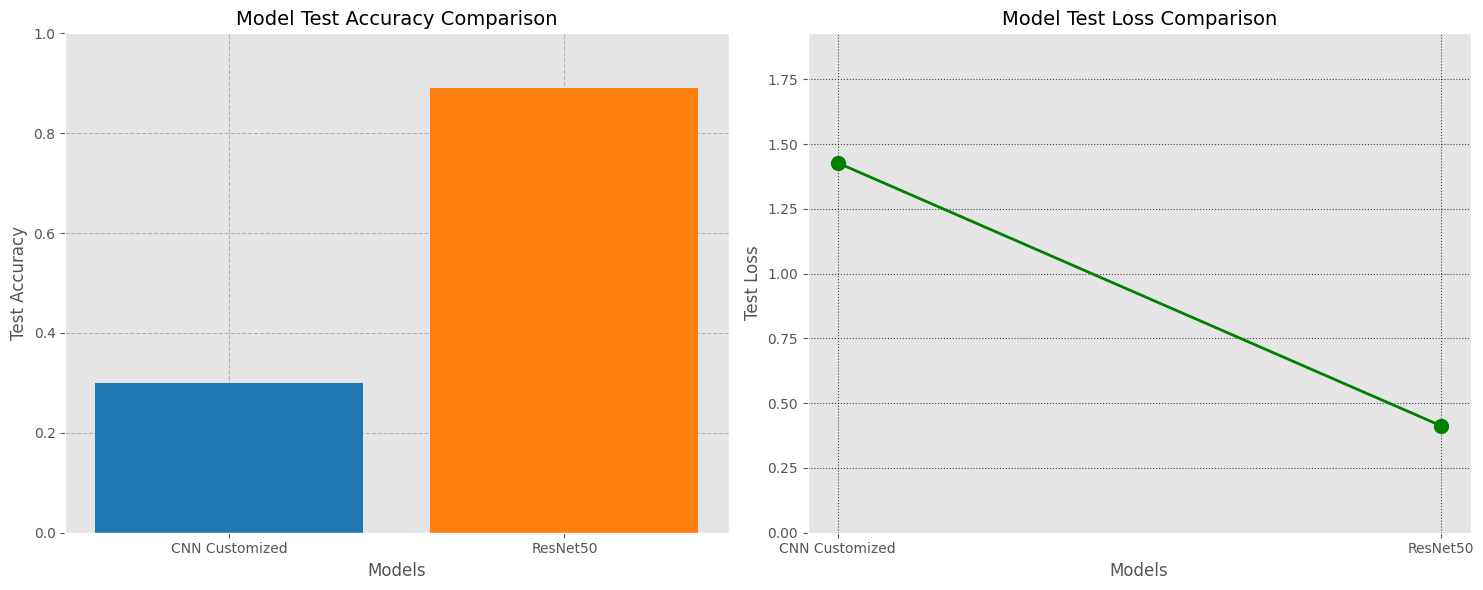

In [39]:
import matplotlib.pyplot as plt
import numpy as np


plt.style.use('ggplot')

models = ['CNN Customized', 'ResNet50']
accuracies = [0.30, 0.89]
losses = [1.4277, 0.4135]
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(models, accuracies, color=['#1f77b4', '#ff7f0e'])
axes[0].set_title('Model Test Accuracy Comparison', fontsize=14)
axes[0].set_xlabel('Models', fontsize=12)
axes[0].set_ylabel('Test Accuracy', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].grid(True, linestyle='--', which='major', color='gray', alpha=0.5)

axes[1].plot(models, losses, 'p-', marker='o', color='green', markersize=10, linewidth=2)
axes[1].set_title('Model Test Loss Comparison', fontsize=14)
axes[1].set_xlabel('Models', fontsize=12)
axes[1].set_ylabel('Test Loss', fontsize=12)
axes[1].set_ylim([0, max(losses) + 0.5])
axes[1].grid(True, linestyle=':', which='major', color='black', alpha=0.7)

plt.tight_layout()
plt.show()


**Testare manuala**

---



---




Mai jos se pot vizualiza diferite teste ,pe diferite imagini ,in care am oscilat modele si pozele pentru a testa "manual"

1/1 [==============================] - 1s 1s/step
The model predicts the image is: actinic keratosis


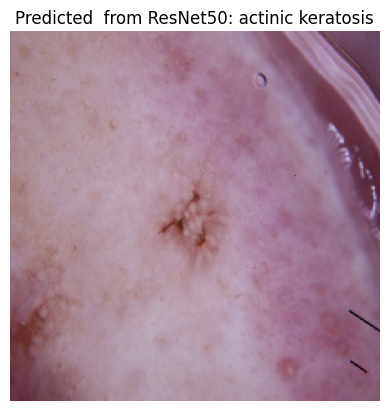

In [43]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size, Image.NEAREST)
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array
img_path = '/content/drive/MyDrive/archive/SkinCancer/Test/actinic keratosis/ISIC_0024511.jpg'

processed_image = preprocess_image(img_path)

prediction = model.predict(processed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]


predicted_class = classes[predicted_class_index]

print(f'The model predicts the image is: {predicted_class}')

plt.imshow(np.squeeze(processed_image))
plt.title(f'Predicted  from ResNet50: {predicted_class}')
plt.axis('off')
plt.show()


1/1 [==============================] - 2s 2s/step
The model predicts the image is: melanoma


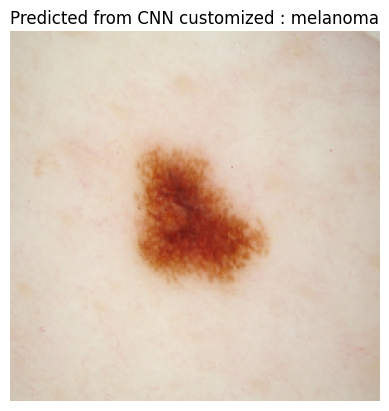

In [73]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size, Image.NEAREST)
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array
    classes = ['pigmented benign keratosis', 'melanoma', 'vascular lesion', 'actinic keratosis',
           'squamous cell carcinoma', 'basal cell carcinoma', 'seborrheic keratosis',
           'dermatofibroma', 'nevus']
img_path = '/content/drive/MyDrive/archive/SkinCancer/Train/melanoma/ISIC_0011163.jpg'

processed_image = preprocess_image(img_path)

prediction = model_1.predict(processed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]

predicted_class = classes[predicted_class_index]

print(f'The model predicts the image is: {predicted_class}')

plt.imshow(np.squeeze(processed_image))
plt.title(f'Predicted from CNN customized : {predicted_class}')
plt.axis('off')
plt.show()


1/1 [==============================] - 2s 2s/step
The model predicts the image is: pigmented benign keratosis


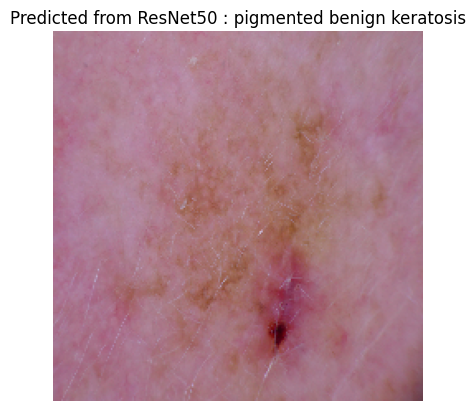

In [44]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model_1 = Model(inputs=base_model.input, outputs=predictions)

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size, Image.NEAREST)
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array
img_path = '/content/drive/MyDrive/archive/SkinCancer/Train/pigmented benign keratosis/ISIC_0028622.jpg'

classes = ['pigmented benign keratosis', 'melanoma', 'vascular lesion', 'actinic keratosis',
           'squamous cell carcinoma', 'basal cell carcinoma', 'seborrheic keratosis',
           'dermatofibroma', 'nevus']

processed_image = preprocess_image(img_path)

prediction = model.predict(processed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

print(f'The model predicts the image is: {predicted_class}')

plt.imshow(np.squeeze(processed_image))
plt.title(f'Predicted from ResNet50 : {predicted_class}')
plt.axis('off')
plt.show()


1/1 [==============================] - 4s 4s/step
The model predicts the image is: pigmented benign keratosis


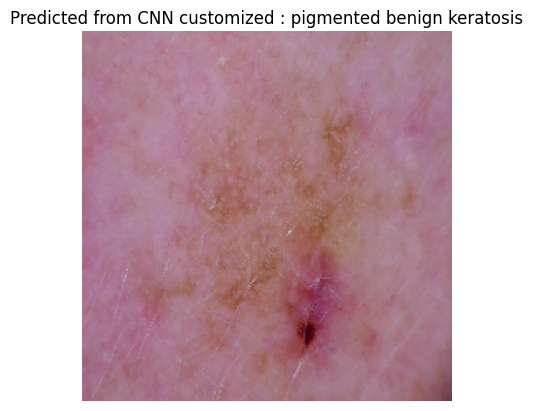

In [45]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size, Image.NEAREST)
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array
    classes = ['pigmented benign keratosis', 'melanoma', 'vascular lesion', 'actinic keratosis',
           'squamous cell carcinoma', 'basal cell carcinoma', 'seborrheic keratosis',
           'dermatofibroma', 'nevus']
img_path = '/content/drive/MyDrive/archive/SkinCancer/Train/pigmented benign keratosis/ISIC_0028622.jpg'

processed_image = preprocess_image(img_path)

prediction = model_1.predict(processed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]

predicted_class = classes[predicted_class_index]

print(f'The model predicts the image is: {predicted_class}')

plt.imshow(np.squeeze(processed_image))
plt.title(f'Predicted from CNN customized : {predicted_class}')
plt.axis('off')
plt.show()


1/1 [==============================] - 2s 2s/step
The model predicts the image is: melanoma


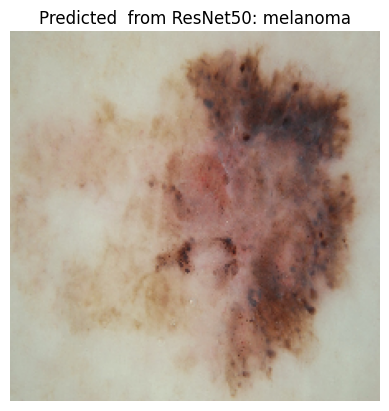

In [71]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)
img_path = '/content/drive/MyDrive/archive/SkinCancer/Train/melanoma/ISIC_0011163.jpg'


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size, Image.NEAREST)
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

classes = ['melanoma','pigmented benign keratosis']
img_path = '/content/drive/MyDrive/archive/SkinCancer/Train/melanoma/ISIC_0010965.jpg'


processed_image = preprocess_image(img_path)

prediction = model.predict(processed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]


predicted_class = classes[predicted_class_index]

print(f'The model predicts the image is: {predicted_class}')

plt.imshow(np.squeeze(processed_image))
plt.title(f'Predicted  from ResNet50: {predicted_class}')
plt.axis('off')
plt.show()
